In [96]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.integrate import odeint 
from matplotlib import gridspec

  
# HH方程参数定义  
# 膜电容（单位：μF/cm²）  
C_m = 0.01
# 钠离子通道最大电导（单位：mS/cm²）  
g_Na = 1.2 
# 钾离子通道最大电导（单位：mS/cm²）  
g_K = 0.36
# 漏电流通道最大电导（单位：mS/cm²）  
g_L = 0.003
# 钠离子反转电位（单位：mV）  
E_Na = 50.0  
# 钾离子反转电位（单位：mV）  
E_K = -77.0  
# 漏电流反转电位（单位：mV）  
E_L = -54.387 
# 静息电位（单位：mV）  
V_rest = -65.0  

In [97]:
# 离子通道门控变量（激活和失活）及其参数  
# m是钠离子通道激活变量  
# h是钠离子通道失活变量  
# n是钾离子通道激活变量  
# alpha和beta是门控变量的速率常数  
  
# 钠离子通道激活变量m的速率常数  
def alpha_m(V):  
    return 0.1 * (V+40.0) / (1.0 - np.exp(-(V +40.0) / 10.0))  
  
def beta_m(V):  
    return 4.0 * np.exp(-0.0556*(V +65.0) )  
  
# 钠离子通道失活变量h的速率常数  
def alpha_h(V):  
    return 0.07 * np.exp(-(V +65.0) / 20.0)  
  
def beta_h(V):  
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))  
  
# 钾离子通道激活变量n的速率常数  
def alpha_n(V):  
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))  
  
def beta_n(V):  
    return 0.125 * np.exp(-(V + 65.0) / 80.0)  
  
# 平衡态的门控变量（当dm/dt=0, dh/dt=0, dn/dt=0时的值）  
def m_inf(V):  
    return alpha_m(V) / (alpha_m(V) + beta_m(V))  
  
def h_inf(V):  
    return alpha_h(V) / (alpha_h(V) + beta_h(V))  
  
def n_inf(V):  
    return alpha_n(V) / (alpha_n(V) + beta_n(V))  
  
# 门控变量的时间常数  
def tau_m(V):  
    return 1.0 / (alpha_m(V) + beta_m(V))  
  
def tau_h(V):  
    return 1.0 / (alpha_h(V) + beta_h(V))  
  
def tau_n(V):  
    return 1.0 / (alpha_n(V) + beta_n(V))  

In [98]:
I0=0.9
t_begin=20
t_end=100

# 外部电流的函数形式 (方波电流)
def external_current(t):
    # 电流为1在200ms到300ms之间，其他时间为0
    return I0 if t_begin <= t <= t_end else 0

In [99]:
# HH方程函数定义  
# 输入：y是状态向量[V, m, h, n]，t是时间  
# 输出：dydt是状态向量的导数[dV/dt, dm/dt, dh/dt, dn/dt]  
def hh_ode(y, t):  
    V, m, h, n = y  
    dm_dt = (m_inf(V) - m) / tau_m(V)  
    dh_dt = (h_inf(V) - h) / tau_h(V)  
    dn_dt = (n_inf(V) - n) / tau_n(V)  
    # 膜电位的变化率  
    I=external_current(t)
     
    dV_dt = ( I+ g_Na * m**3 * h * (E_Na - V) + g_K * n**4 * (E_K - V) + g_L * (E_L - V)) / C_m  
    return [dV_dt, dm_dt, dh_dt, dn_dt]  
    

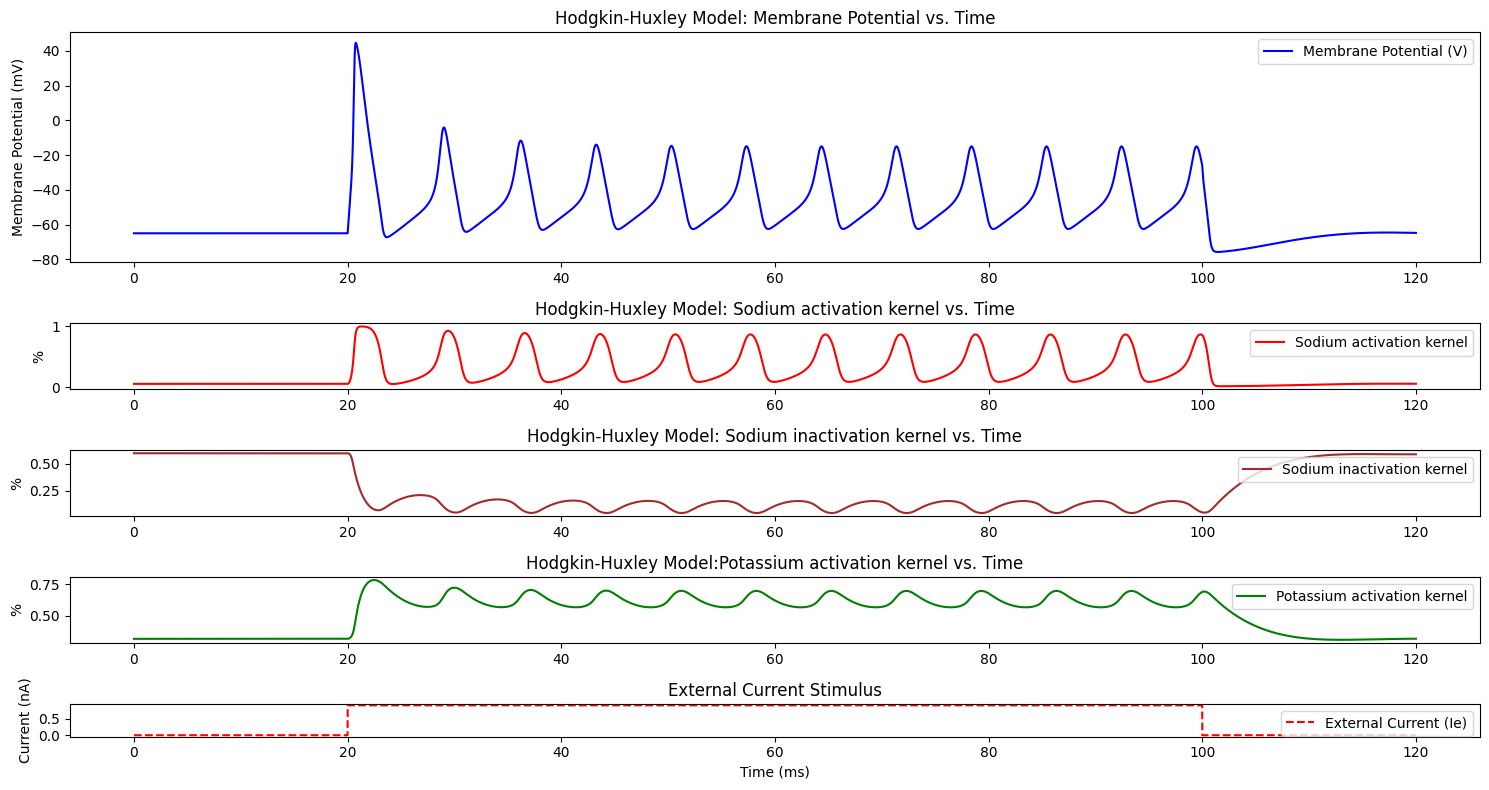

In [100]:
# 初始条件设置  
# 初始膜电位设为静息电位  
V0 = V_rest  
# 初始的门控变量设为它们的平衡态值  
m0 = m_inf(V0)  
h0 = h_inf(V0)  
n0 = n_inf(V0)  
# 初始状态向量  
y0 = [V0, m0, h0, n0]  
  
# 时间向量设置  
# 这里我们可以设置模拟时间，时间步长为0.01毫秒  
t = np.linspace(0, 120, 10001)  
  
# 使用odeint求解微分方程  
# 返回的是状态向量y随时间t的解  
sol = odeint(hh_ode, y0, t)  
  
# 提取膜电位V  
V = sol[:, 0]  
m = sol[:, 1]  
h = sol[:, 2]  
n = sol[:, 3]  

  
# 绘制膜电位和电流图形
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(5, 1, height_ratios=[7,2,2,2, 1])  # 设置图形的高度比例

# 第一部分：膜电位图
ax0 = plt.subplot(gs[0])
ax0.plot(t, V, label='Membrane Potential (V)', color='blue')
ax0.set_ylabel('Membrane Potential (mV)')
ax0.set_title('Hodgkin-Huxley Model: Membrane Potential vs. Time')
ax0.legend(loc="upper right")

ax0 = plt.subplot(gs[1])
ax0.plot(t, m, label='Sodium activation kernel', color='red')
ax0.set_ylabel('%')
ax0.set_title('Hodgkin-Huxley Model: Sodium activation kernel vs. Time')
ax0.legend(loc="upper right")

ax0 = plt.subplot(gs[2])
ax0.plot(t, h, label='Sodium inactivation kernel', color='brown')
ax0.set_ylabel('%')
ax0.set_title('Hodgkin-Huxley Model: Sodium inactivation kernel vs. Time')
ax0.legend(loc="upper right")

ax0 = plt.subplot(gs[3])
ax0.plot(t, n, label='Potassium activation kernel', color='green')
ax0.set_ylabel('%')
ax0.set_title('Hodgkin-Huxley Model:Potassium activation kernel vs. Time')
ax0.legend(loc="upper right")

# 第二部分：电流刺激图
ax1 = plt.subplot(gs[4])
I_values = np.array([external_current(tt) for tt in t])
ax1.plot(t, I_values, label='External Current (Ie)', color='red', linestyle='--')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current (nA)')
ax1.set_title('External Current Stimulus')
ax1.legend(loc="upper right")

# 调整布局，防止重叠
plt.tight_layout()

# 显示图形
plt.show()
